# LLM Study Group Notebook: Kaggle Competition - Fraud Detection

This notebook is intended for the LLM Study Group and focuses on the Kaggle competition for fraud detection.

## Overview

The **IEEE-CIS Fraud Detection** competition is hosted on Kaggle in partnership with IEEE and the Data Science Institute (CIS). The competition aims to develop models that can accurately identify fraudulent transactions using machine learning techniques.

## Competition Details

- **Host**: Kaggle, IEEE, and the Data Science Institute (CIS)
- **Objective**: Create a machine learning model to detect fraudulent transactions.
- **Data Source**: Kaggle competition dataset

## Sections

### 0. Data Import from Kaggle

**Description**: Import the dataset provided by the IEEE-CIS Fraud Detection competition. This data will be used for building and evaluating the fraud detection model.
**Resource**: [Kaggle Competition Data](https://www.kaggle.com/competitions/ieee-fraud-detection/data)


### 1. Exploratory Data Analysis (EDA)

- **Description**: Analyze the dataset to understand its structure, distribution, and any underlying patterns.
- **Tasks**:
  - Data Cleaning
  - Feature Exploration
  - Visualization
  
### 2. Model Selection

- **Description**: Select and implement suitable machine learning algorithms to tackle the fraud detection problem. Evaluate different models to determine which best meets the objectives of the competition.

- **Tasks**:
  - **Model Comparison**:
    - **Neural Network (NN) Model**:
      - **Layer Normalization**: Explore the impact of layer normalization on model performance and stability.
    - **Gradient Boosting Decision Trees (GBDT) Model**:
      - **Overview**: Evaluate the effectiveness of GBDT models, such as XGBoost or LightGBM.
    - **Rationale**: Justify the choice of models based on their performance, interpretability, and suitability for the fraud detection task.
  - **Hyperparameter Tuning**:
    - Optimize hyperparameters for each selected model to improve performance and prevent overfitting.
  - **Model Training and Validation**:
    - Train models using the training dataset.
    - Validate models using cross-validation or a validation set to assess their generalization capability.

### 3. Metrics & Error Analysis

- **Description**: Assess model performance using various metrics and perform error analysis to identify areas for improvement.

- **Tasks**:
  - **Performance Metrics**:
    - **AUC-ROC**: Evaluate the model’s ability to distinguish between fraudulent and non-fraudulent transactions.
    - **Log Loss**: Measure the accuracy of predicted probabilities.
    - **Recall and Precision**: Assess the model’s ability to correctly identify fraudulent transactions (recall) and the proportion of correctly identified fraudulent transactions out of all predicted fraudulent ones (precision).
  - **Comparison of Metrics**:
    - Discuss the advantages and limitations of each metric in the context of the fraud detection task.
  - **Error Analysis**:
    - Analyze misclassified transactions to understand where and why errors occur.
  - **Model Interpretation**:
    - Interpret model predictions and feature importances to gain insights into the model's decision-making process and identify potential areas for improvement.


### 4. Enhancement Rollout Plan

- **Description**: Plan for enhancing the model and improving data quality. This includes identifying and addressing areas for improvement in both the model and the data, and ensuring a smooth transition to deployment.

- **Tasks**:
  - **Identify Areas for Improvement**:
    - **Model Performance**: Analyze current model performance and identify specific areas for improvement, such as accuracy, precision, recall, or other relevant metrics.
    - **Data Quality**: Evaluate data quality and identify any issues such as missing values, outliers, or data imbalances.
    - **Feature Engineering**: Determine if additional feature engineering or new features could enhance model performance.
  - **Implement Enhancements**:
    - **Model Enhancements**:
      - Apply advanced techniques such as hyperparameter tuning, model ensembling, or exploring alternative algorithms to improve performance.
    - **Data Improvements**:
      - **Data Cleaning**: Address issues in the dataset by handling missing values, correcting inconsistencies, and removing or mitigating outliers.
      - **Feature Engineering**: Develop new features or modify existing ones to provide more meaningful inputs to the model, enhancing its predictive power.
      - **Data Augmentation**: Increase the diversity and volume of the training data through techniques such as oversampling underrepresented classes, generating synthetic samples, or incorporating additional relevant data.
      - **Re-calibration (if needed)**: Adjust the model’s probability outputs or decision thresholds to improve performance metrics or better align with business objectives.


## Section 0: Data Import from Kaggle

In [ ]:
# !pip install kaggle
# !mv ~/Downloads/kaggle.json .
# !mkdir -p ~/.kaggle 
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls

In [ ]:
#set up the Kaggle API credentials
import os
import json

kaggle_json_path = 'kaggle.json'

with open(kaggle_json_path) as f:
    kaggle_json = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

In [ ]:
!kaggle competitions download -c ieee-fraud-detection

In [ ]:
# !unzip ieee-fraud-detection.zip && mkdir data && mv *.csv data

## Section1: Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd

TRAN_PATH = "data/train_transaction.csv"
ID_PATH = "data/train_identity.csv"

transaction_df = pd.read_csv(TRAN_PATH)
id_df = pd.read_csv(ID_PATH)
sampled_transaction_df = transaction_df.sample(n=30000, random_state=42)

train_df = sampled_transaction_df.merge(id_df, on='TransactionID', how='left')

In [2]:
import pandas as pd

TRAN_PATH = "data/test_transaction.csv"
ID_PATH = "data/test_identity.csv"

transaction_df = pd.read_csv(TRAN_PATH)
sampled_transaction_df = transaction_df.sample(n=30000, random_state=42)
id_df = pd.read_csv(ID_PATH)

test_df = transaction_df.merge(id_df, on='TransactionID', how='left')

## Section 2. Model Selection

In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import time

categorical_features_transaction = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

categorical_features_identity = [
    'DeviceType', 'DeviceInfo'
] + [f'id_{i}' for i in range(12, 39)]

categorical_features = categorical_features_transaction + categorical_features_identity

numerical_features = [col for col in train_df.columns if col not in categorical_features and col != 'isFraud']

target = 'isFraud'

X = train_df[categorical_features + numerical_features]
y = train_df[target].values

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import time

class NN_Model_with_LN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NN_Model_with_LN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.ln1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 16)
        self.ln2 = nn.LayerNorm(16)
        self.fc3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.ln1(x)
        x = torch.relu(self.fc2(x))
        x = self.ln2(x)
        x = self.fc3(x)
        return x

class NN_Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NN_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NN_Model_with_Dropout(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NN_Model_with_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x    

class NN_Model_LN_with_Dropout(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NN_Model_LN_with_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.ln1 = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.ln2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.ln1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.ln2(x)
        x = self.fc3(x)
        return x 
    
def train_model(num_epoch, model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor, patience=10, apply_early_stop = False):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    start_time = time.time()
    
    for epoch in range(num_epoch):
        model.train()
        epoch_train_loss = 0
        all_train_preds = []
        all_train_labels = []
        
        for batch_X, batch_y in train_dataloader:
            optimizer.zero_grad()
            
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            all_train_preds.extend(preds.numpy())
            all_train_labels.extend(batch_y.numpy())
        
        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)
        
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_train_labels, all_train_preds, average='binary')
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor).squeeze()
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)

            val_preds = torch.sigmoid(val_outputs) > 0.5
            val_accuracy = accuracy_score(y_val, val_preds.numpy())
            val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, val_preds.numpy(), average='binary')

            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)
        
#         print(f'Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, '
#               f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, '
#               f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')
        
        if apply_early_stop:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    break
                
    end_time = time.time()
    total_training_time = end_time - start_time
    print(f'Total Training Time: {total_training_time:.2f}s')
    
    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores

def plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores):
    plt.figure(figsize=(18, 6))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curve')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Learning Curve')
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Learning Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Without linear normalization

Total Training Time: 13.76s


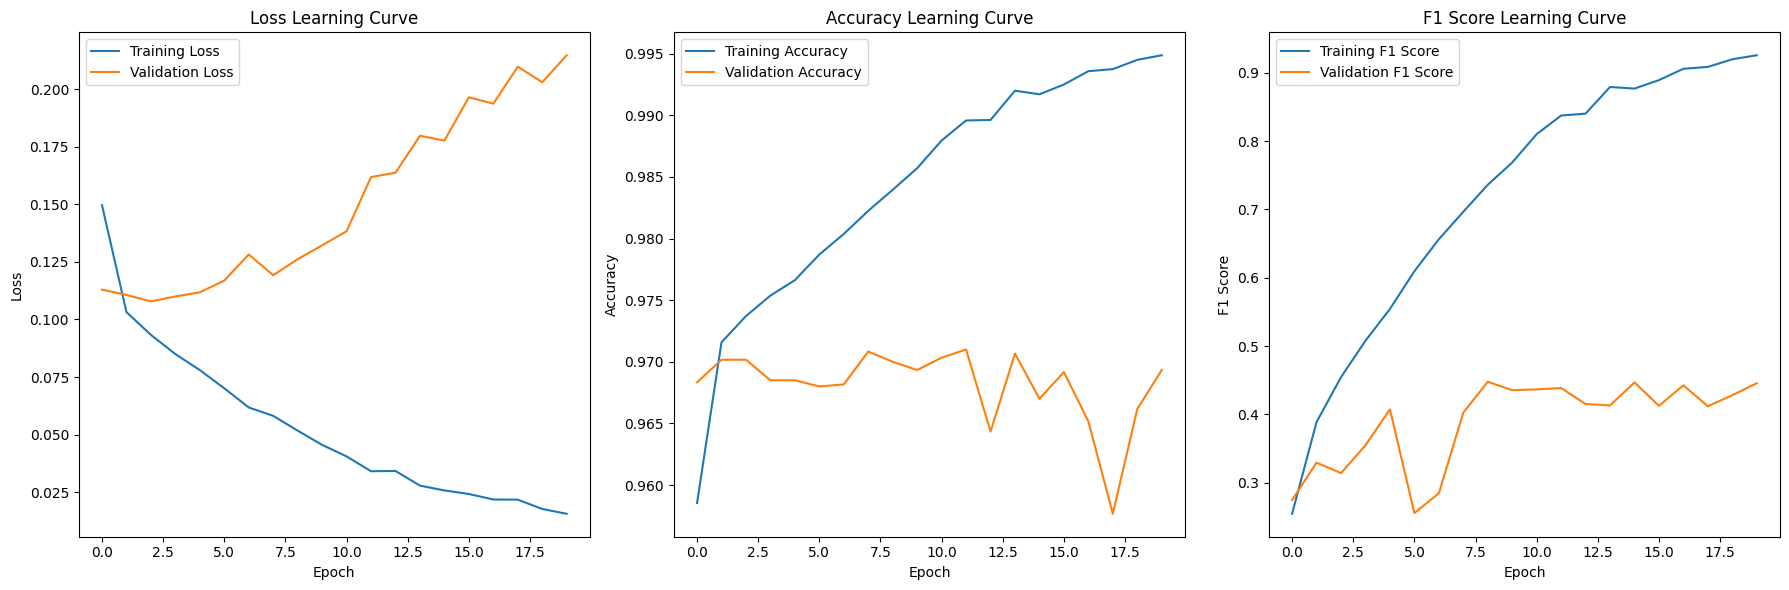

In [36]:
input_dim = X_processed.shape[1]
output_dim = 1

criterion = nn.BCEWithLogitsLoss()

NN_model = NN_Model(input_dim, output_dim)

NN_model_optimizer = optim.Adam(NN_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(20,
    NN_model, criterion, NN_model_optimizer, train_dataloader, X_val_tensor, y_val_tensor
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores)

## With linear normalization

Total Training Time: 15.10s


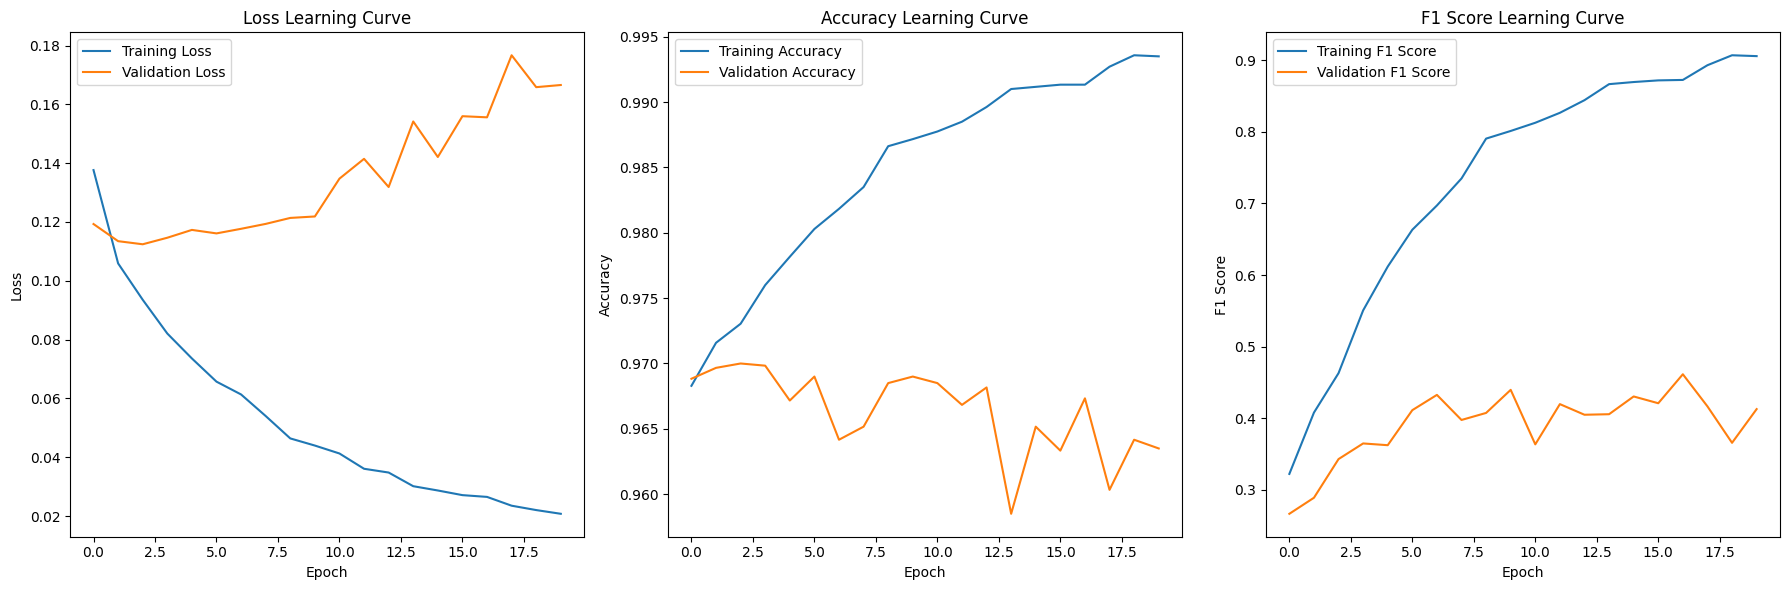

In [37]:
NN_LN_Model = NN_Model_with_LN(input_dim, output_dim)

optimizer = optim.Adam(NN_LN_Model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(
    20, NN_LN_Model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores) 

By comparing the learning curves of the loss for the two models, we observe that after the same number of epochs, the model with normalization achieves a much lower loss compared to the model without normalization.

## Identifying overfitting

## Overfitting to Majority Class - Apply class weight

Total Training Time: 37.47s


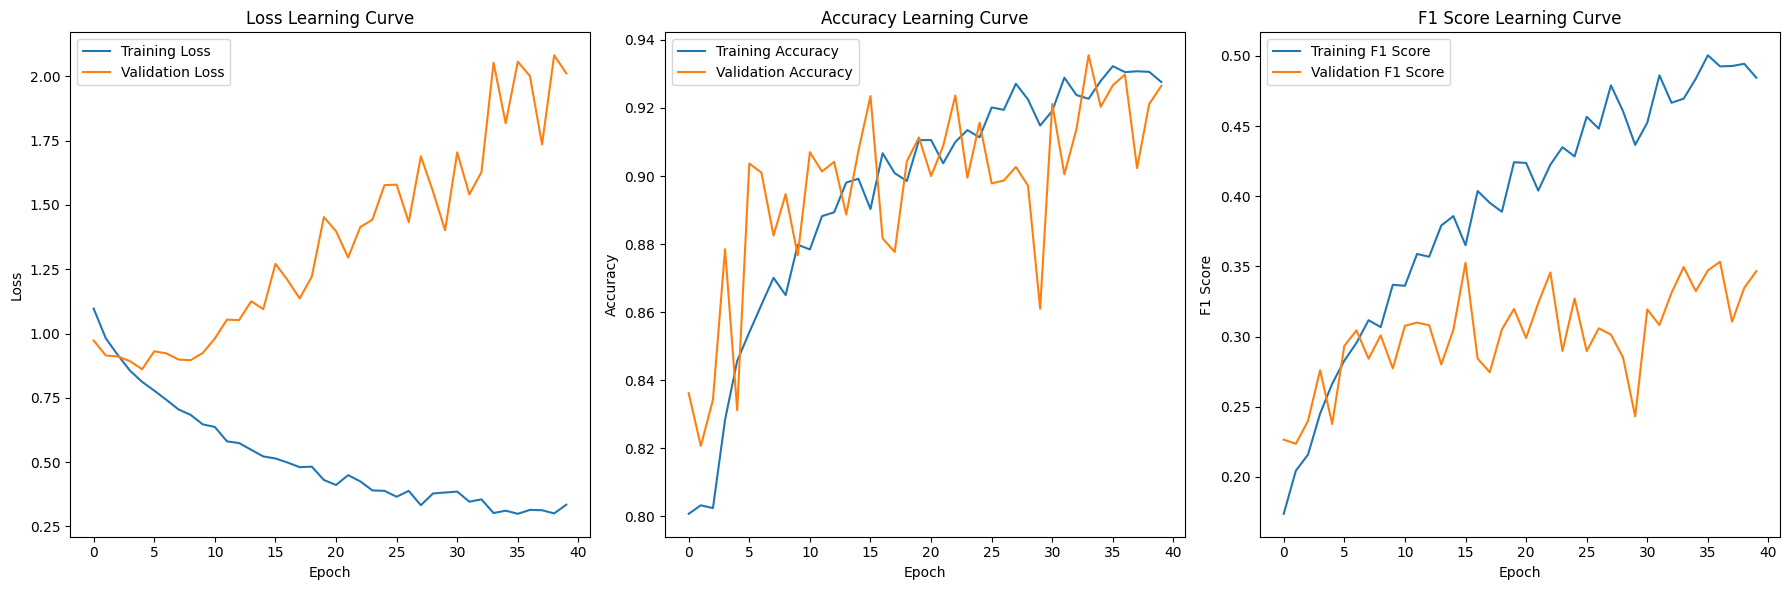

In [38]:
num_fraud_samples = train_df[train_df[target] == 1].shape[0]
num_non_fraud_samples = train_df[train_df[target] == 0].shape[0]

pos_weight = num_non_fraud_samples / num_fraud_samples
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

NN_model = NN_Model_with_Dropout(input_dim, output_dim)

optimizer = optim.Adam(NN_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(40,
    NN_model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores)

Total Training Time: 43.36s


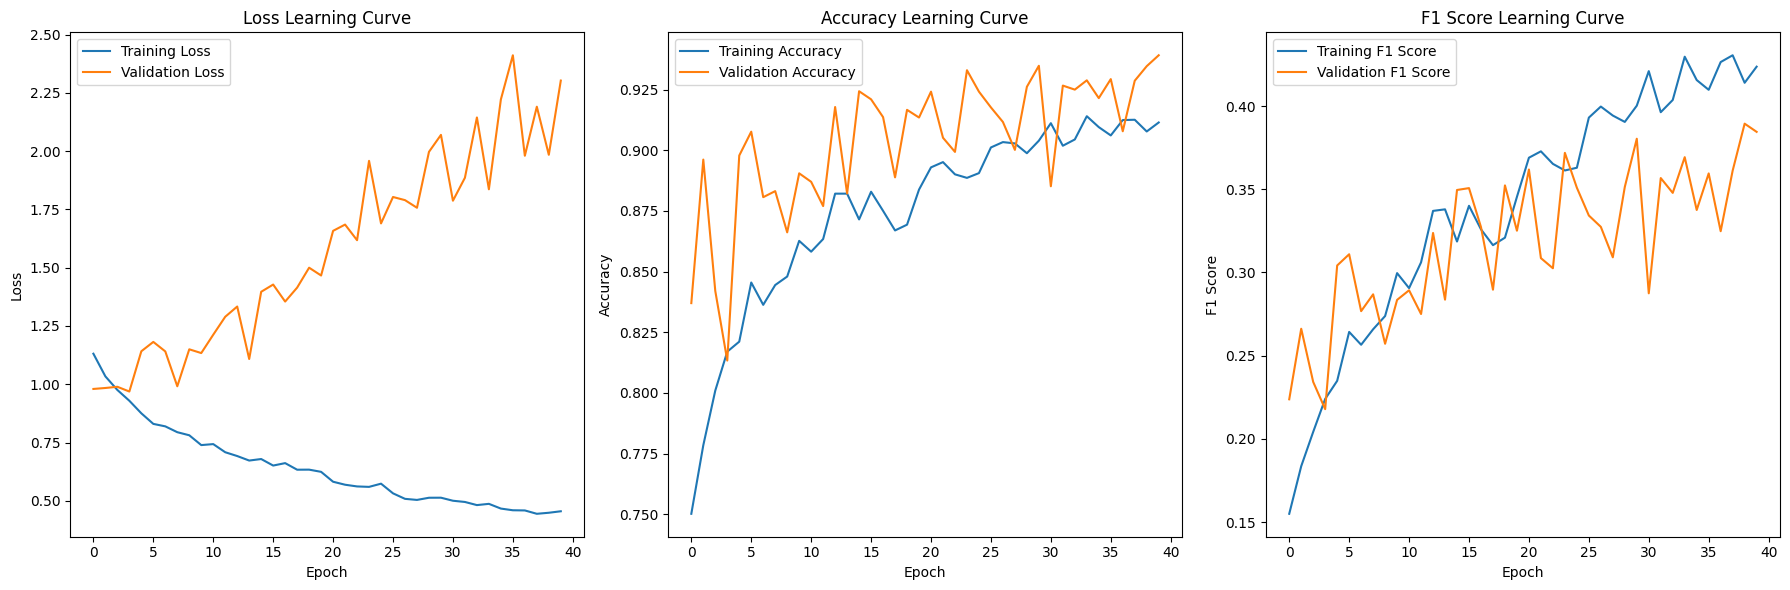

In [44]:
pos_weight = num_non_fraud_samples / num_fraud_samples
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

NN_model = NN_Model_LN_with_Dropout(input_dim, output_dim)

optimizer = optim.Adam(NN_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(40,
    NN_model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores)

## Apply drop out + early stop

Early stopping due to no improvement in validation loss.
Total Training Time: 13.91s


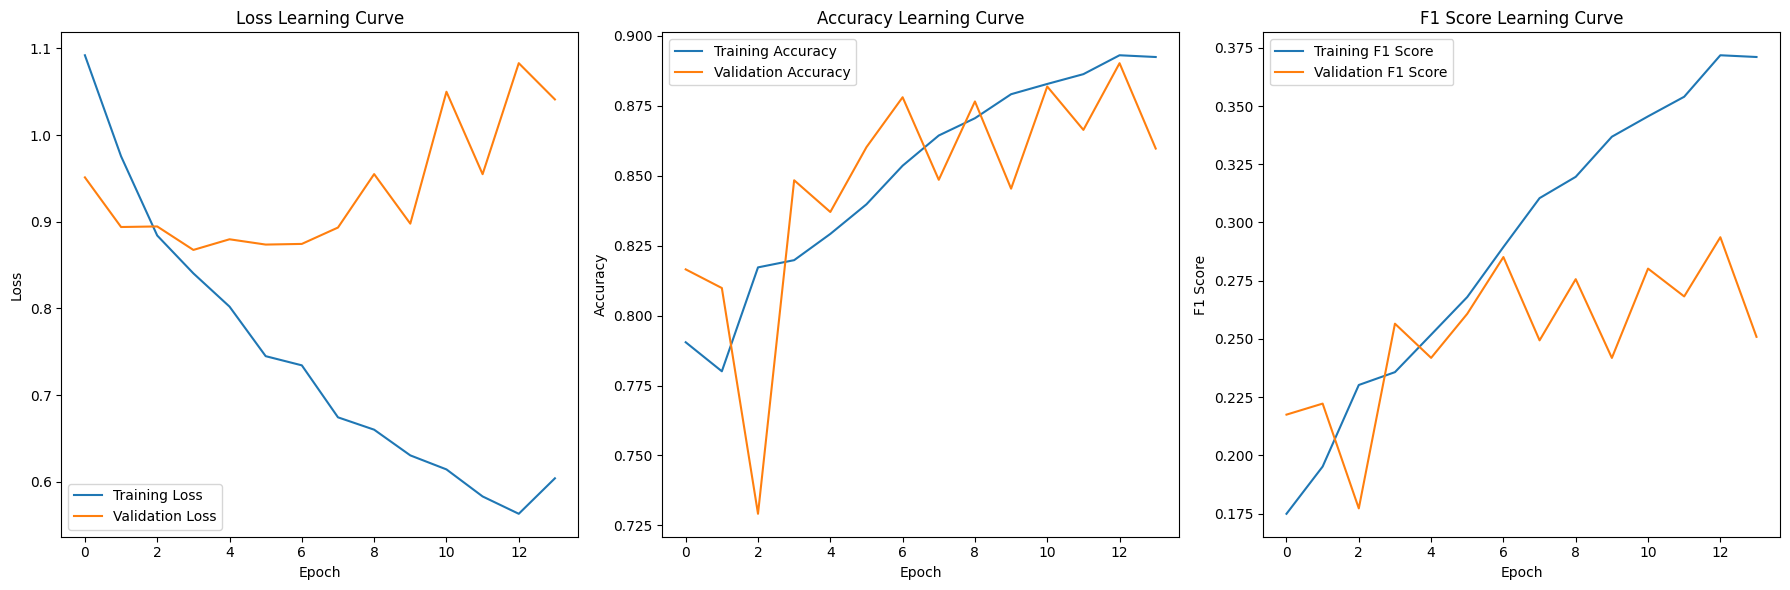

In [46]:
NN_model = NN_Model_with_Dropout(input_dim, output_dim)

optimizer = optim.Adam(NN_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(40,
    NN_model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor, apply_early_stop = True
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores)

Early stopping due to no improvement in validation loss.
Total Training Time: 10.12s


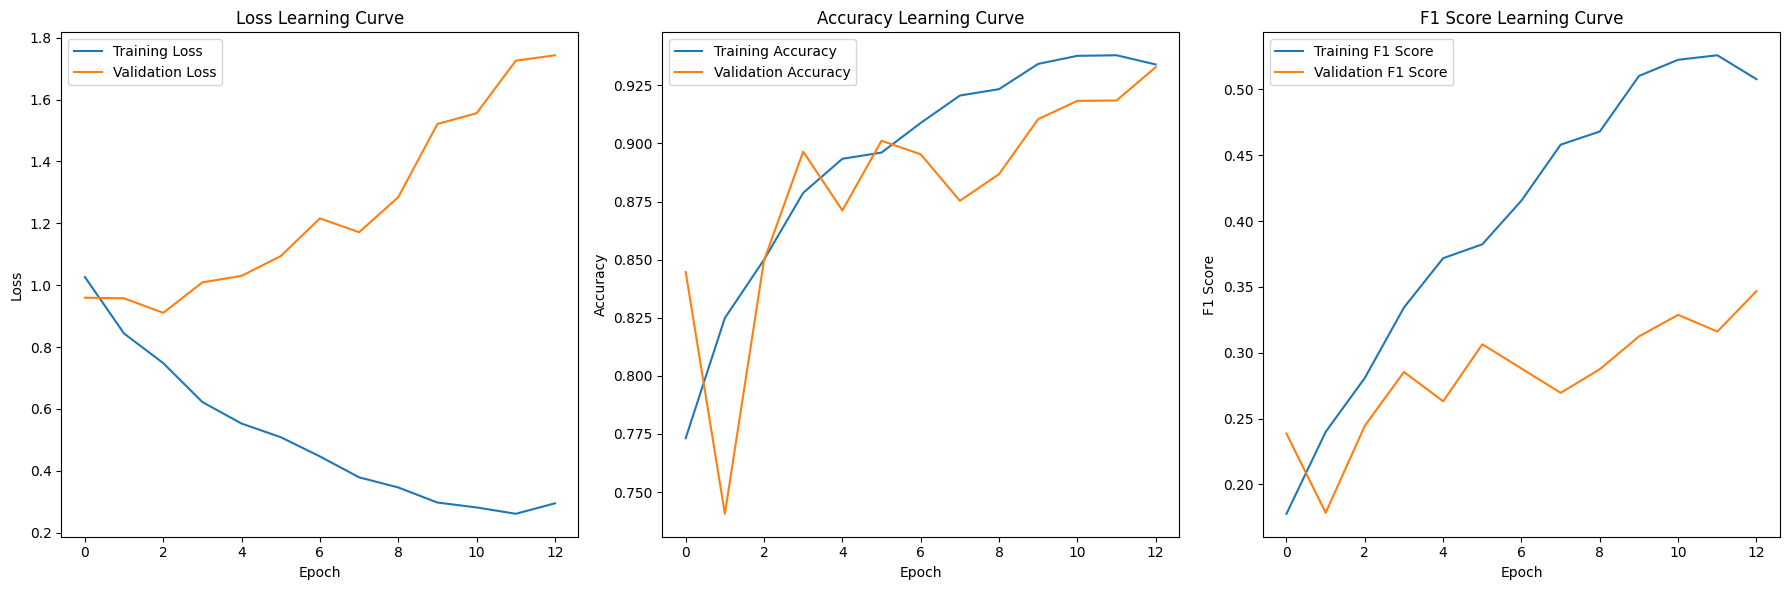

In [47]:
NN_LN_Model = NN_Model_with_LN(input_dim, output_dim)

optimizer = optim.Adam(NN_LN_Model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores = train_model(
    40, NN_LN_Model, criterion, optimizer, train_dataloader, X_val_tensor, y_val_tensor, apply_early_stop = True
)

plot_learning_curve(train_losses, val_losses,train_accuracies,val_accuracies,train_f1_scores,val_f1_scores)

Apply early stopping to evaluate if the model converges more quickly. The results indicate that with normalization, the model converges faster and requires less training time.


### Batch Normalization and Layer Normalization

**Batch Normalization (BN)** and **Layer Normalization (LN)** are techniques used to normalize activations in neural networks to improve training stability and performance.

#### Batch Normalization

**Batch Normalization** normalizes the activations of a neural network across a mini-batch of data.

**How it Works**:
- For each activation in a **given layer**, BN computes the mean and variance of the activations across the entire mini-batch. The activations are then normalized using these batch statistics.
- After normalization, BN applies learnable parameters to scale (\(\gamma\)) and shift (\(\beta\)) the activations. 
- The purpose of these parameters is to mitigate the potential limitations of normalization. After normalization, the activations have a mean of 0 and a standard deviation of 1, which might impose restrictions on the network. For instance, normalizing to a mean of 0 with ReLU activation functions can force half of the outputs to be 0, leading to a loss of information. The scaling and shifting parameters allow the network to adjust and learn the optimal output distribution.

#### Layer Normalization

**Layer Normalization** For each activation in a **given layer**, Layer Normalization (LN) computes the mean and variance of the activations across the features of each individual data instance. The activations are then normalized using these instance-specific statistics, not batch statistics. 

**How it Works**:
- For each data instance, LN computes the mean and variance of the activations across all features of that instance.
- Similar to BN, LN then normalizes the activations using these instance-specific statistics and applies learnable parameters to scale (\(\gamma\)) and shift (\(\beta\)) the activations.

Both BN and LN help in stabilizing training and improving network performance, but they are applied in different contexts depending on the nature of the data and the network architecture.

## **Effectiveness in Different Contexts**

- **Batch Normalization (BN)**
  - **Effective For**: Deep networks where training stability is crucial. Particularly useful in CNNs where feature maps have consistent statistical properties across batches.
  - **Limitation**: May not perform well with variable-length sequences or when batch sizes fluctuate.

- **Layer Normalization (LN)**
  - **Effective For**: Models with variable-length sequences, such as Transformers and RNNs. Helps in maintaining consistency across different instances regardless of batch size.
  - **Limitation**: May not exploit batch-wise statistics, which can be beneficial for large batch sizes and fixed-size inputs.

#### **Training Dynamics**

- **Batch Normalization (BN)**
  - **Impact**: Reduces internal covariate shift and can accelerate training by allowing for higher learning rates. Often used with convolutional layers in CNNs.

- **Layer Normalization (LN)**
  - **Impact**: Stabilizes training for sequential models by normalizing each instance separately. Helps in scenarios where sequences or instances have variable lengths.

### Summary

- **Batch Normalization** is effective for stabilizing and accelerating training in deep networks with consistent batch sizes and fixed-size inputs. It normalizes across the batch and applies scaling and shifting parameters to the activations.

- **Layer Normalization** is better suited for models with variable-length sequences or where batch sizes vary. It normalizes across features of each individual instance, making it adaptable to tasks involving sequential data and varying input sizes. 

Both techniques aim to stabilize training and improve performance but are chosen based on the specific requirements and architecture of the neural network.

If normalization techniques like Batch Normalization (BN) or Layer Normalization (LN) are not used in neural network training, several issues can arise, negatively impacting the training process and model performance. Here’s how and why the absence of normalization can affect training:

### **Effects of Not Using Normalization**

1. **Internal Covariate Shift**
   - **Definition**: Internal covariate shift refers to the change in the distribution of activations in a network layer during training as the parameters of previous layers change. This shift can make the training process less stable.
   - **Impact**: Without normalization, activations can vary widely between layers, leading to inconsistent distributions that make it harder for the network to learn effectively. This can slow down training and require more careful tuning of hyperparameters like learning rate.

2. **Vanishing and Exploding Gradients**
   - **Definition**: The vanishing gradient problem occurs when gradients become very small during backpropagation, leading to slow or stalled learning. The exploding gradient problem occurs when gradients become excessively large, causing unstable training.
   - **Impact**: Normalization helps mitigate these issues by maintaining more stable activations and gradients. Without normalization, the network is more likely to suffer from these problems, particularly in deep networks or recurrent networks.

3. **Difficulties in Training Deep Networks**
   - **Definition**: Deep neural networks are more prone to issues like internal covariate shift, vanishing gradients, and exploding gradients due to their depth.
   - **Impact**: Normalization techniques help stabilize the training of deep networks by normalizing activations and gradients. Without normalization, training deep networks becomes more challenging, often requiring careful initialization and learning rate adjustments.

4. **Increased Sensitivity to Hyperparameters**
   - **Definition**: Hyperparameters like learning rate, weight initialization, and regularization parameters play a crucial role in the training process.
   - **Impact**: Normalization can reduce sensitivity to hyperparameter settings. Without normalization, the training process becomes more sensitive to hyperparameters, making it more difficult to find suitable values that allow for effective training.

5. **Slower Convergence**
   - **Definition**: Convergence refers to the process of a model’s parameters approaching optimal values during training.
   - **Impact**: Normalization techniques can accelerate convergence by stabilizing and speeding up training. Without normalization, the network may converge more slowly due to the issues mentioned above, requiring more epochs and computational resources to achieve good performance.

6. **Inconsistent Training Dynamics**
   - **Definition**: Training dynamics refer to how the model learns and updates its weights over time.
   - **Impact**: Normalization helps ensure consistent and predictable training dynamics. Without normalization, training can become erratic and less predictable, potentially leading to suboptimal solutions.


### In what scenarios does Batch Normalization work better?
**In what scenarios does Batch Normalization work better?**

Batch Normalization (BN) works particularly well in scenarios where the following conditions are met:

### 1. **Stable Batch Sizes and Sequence Lengths**
- **Consistent Batch Sizes**: BN performs best when the batch sizes are relatively large and consistent. This is because BN relies on computing the mean and variance of activations across the batch, and stable batch sizes ensure that these statistics are reliable and representative of the overall data distribution.
- **Fixed Sequence Lengths**: BN is effective when dealing with fixed-size inputs or sequences where the length does not vary significantly, such as images with a consistent resolution.

### 2. **Convolutional Neural Networks (CNNs)**

- **Image Processing**: In computer vision tasks, especially with CNNs, BN works well because the feature channels have relatively consistent statistical properties across the batch. The mean and variance calculated over the batch provide stable normalization for the activations of each channel.

Batch Normalization works best in scenarios where batch sizes are consistent and large, sequence lengths are fixed, and the network is deep or complex. It is particularly effective in convolutional neural networks for image processing and in any model where batch-wise normalization can stabilize and accelerate the training process.

### Q: Why Layer Normalization preferred over Batch Norm in Transformers?


### 1. **Sequential Data and Variable-Length Sequences**

- **Variable Sequence Lengths**: Transformers handle sequences of variable lengths (e.g., sentences or documents), which makes BN less suitable because BN relies on batch-wise statistics. BN needs consistent batch sizes and sequence lengths to compute reliable statistics. LN, on the other hand, normalizes across features for each individual sequence independently, making it ideal for variable-length sequences.

### 2. **Batch Statistics vs. Instance Statistics**

- **Batch Normalization (BN)**: BN normalizes activations based on the mean and variance computed over the entire batch. This approach is effective when the data distribution is relatively stable across the batch. However, in NLP tasks where sequences vary greatly in length and content, batch-wise statistics might not be reliable or meaningful.
- **Layer Normalization (LN)**: LN normalizes activations across features for each individual instance (sequence) rather than across the batch. This ensures that normalization is applied uniformly regardless of the sequence length or batch size, which is more appropriate for the diverse and variable nature of text data.

### 3. **Normalization in Attention Mechanisms**

- **Attention Mechanisms**: Transformers use self-attention mechanisms where each token in a sequence attends to every other token. This attention process operates at the token level and involves complex interactions between tokens. LN is applied to each token's representation independently, which aligns well with the attention mechanism and maintains consistency across different tokens in the sequence.
- **Consistency in Token Representations**: LN ensures that the representation of each token is normalized in the same way, which helps stabilize training and maintain consistent scaling across different tokens and layers.

### Summary

Layer Normalization is preferred in Transformers over Batch Normalization due to its suitability for variable-length sequences, its alignment with the token-level operations of self-attention, and its effectiveness in stabilizing training and gradient flow in deep architectures. LN normalizes activations across features for each sequence individually, making it better suited for the diverse and variable nature of text data processed by Transformers.

## Section 3.  Metrics & Error Analysis

## Section 4. Enhancement Rollout Plan